## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 1. Image Segmentation Using Thresholding

In [ ]:
IMG1 = cv2.imread('../Images/IMG1.jpeg', cv2.IMREAD_GRAYSCALE)

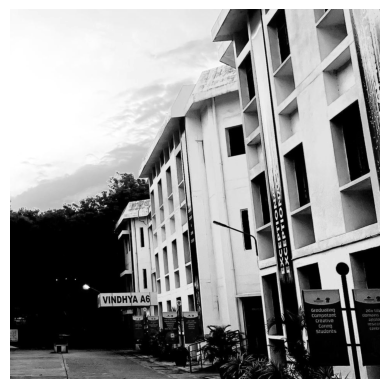

In [ ]:
plt.imshow(IMG1, cmap='gray')
plt.axis('off')
plt.show()

### Thresholding

In [31]:
## Write it without the inbuilt function
def binary_threshold(img, threshold):
    img = img.copy()
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img

def adaptive_threshold(img, block_size, constant):
    img = img.copy()
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = img[i:i+block_size, j:j+block_size]
            threshold = np.mean(block) - constant
            block[block < threshold] = 0
            block[block >= threshold] = 255
    return img

def otsu_threshold(img):
    img = img.copy()
    hist = np.histogram(img, bins=256, range=(0, 256))[0]
    hist = hist / hist.sum()
    cumsum = hist.cumsum()
    mean = np.arange(256)
    mean_cumsum = (mean * hist).cumsum()
    global_mean = mean_cumsum[-1]
    p1 = cumsum
    p2 = 1 - p1
    m1 = mean_cumsum / p1
    m2 = (global_mean - mean_cumsum) / p2
    m1 = np.nan_to_num(m1)
    m2 = np.nan_to_num(m2)
    between_class_variance = p1 * p2 * (m1 - m2) ** 2
    threshold = np.argmax(between_class_variance)
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img

### Displaying

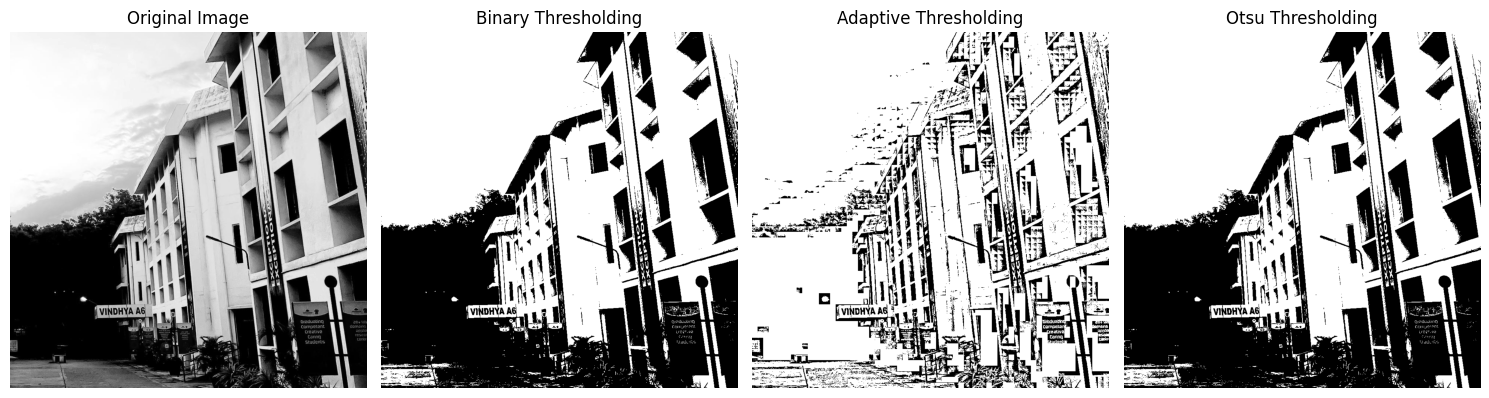

In [37]:
threshold = 120
IMG1_binary = binary_threshold(IMG1, threshold)

## Adaptive Thresholding
block_size = 15
constant = 10
IMG1_adaptive = adaptive_threshold(IMG1, block_size, constant)

## Otsu Thresholding
IMG1_otsu = otsu_threshold(IMG1)

# plot all the images
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(IMG1_binary, cmap='gray')
ax[1].set_title('Binary Thresholding')
ax[1].axis('off')
ax[2].imshow(IMG1_adaptive, cmap='gray')
ax[2].set_title('Adaptive Thresholding')
ax[2].axis('off')
ax[3].imshow(IMG1_otsu, cmap='gray')
ax[3].set_title('Otsu Thresholding')
ax[3].axis('off')
plt.tight_layout()
plt.show()

### Methods, Best Use Cases, and Intuitive Implementation:

1. **Binary Thresholding**  
   - **Best For**: High-contrast images with uniform lighting.  
   - **Method**: It applies a fixed global threshold to the image, meaning pixel values above this threshold are set to a high value (e.g., white), and those below are set to a low value (e.g., black). This works well when the object and background have distinct and consistent intensity differences.  

2. **Adaptive Thresholding**  
   - **Best For**: Images with uneven lighting or varying illumination.  
   - **Method**: Instead of using a single global threshold, adaptive thresholding calculates thresholds for small regions of the image based on the local pixel intensities. This ensures better segmentation in areas where lighting changes across the image.  

3. **Otsu's Thresholding**  
   - **Best For**: Images with a bimodal histogram (two peaks representing object and background).  
   - **Method**: Otsu’s method finds the optimal global threshold by analyzing the intensity distribution of the image. It works well when the pixel intensities naturally cluster into two groups but may struggle with noise or non-bimodal distributions.

In the above images, both **Binary Thresholding** and **Otsu's Thresholding** work great. There is visibly no difference among them. This can also be understood as the image is already high contrast which is good for binary thresholding, and the image has many pixels corresponding to dark and light, which makes the distribution bimodal.

## 2.  Line Detection Using Hough Transform

### Hough Line Transform Function

In [40]:
import numpy as np
import cv2
import math

def hough_line_transform(image, edge_threshold, num_thetas=180):
    # 1. Edge detection (Canny)
    edges = cv2.Canny(image, edge_threshold[0], edge_threshold[1])
    
    # 2. Initialize the Hough Transform parameters
    height, width = edges.shape
    diag_len = int(np.sqrt(height**2 + width**2))  # Max possible distance (ρ)
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)
    thetas = np.linspace(-np.pi / 2, np.pi / 2, num_thetas)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    
    # 3. Populate the accumulator
    edge_points = np.argwhere(edges)  # Get coordinates of edge points
    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta)) + diag_len
            accumulator[rho, theta_idx] += 1
    
    # 4. Detect peaks in the accumulator
    threshold = 0.5 * accumulator.max()  # Simple threshold for peak detection
    line_indices = np.argwhere(accumulator > threshold)
    
    # 5. Convert accumulator indices back to (ρ, θ)
    lines = [(rhos[rho_idx], thetas[theta_idx]) for rho_idx, theta_idx in line_indices]
    
    # 6. Draw lines on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for line drawing
    for rho, theta in lines:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1 = int(x0 + 1000 * (-b))  # Extend the line
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    return output_image, accumulator

### Testing on IMG1

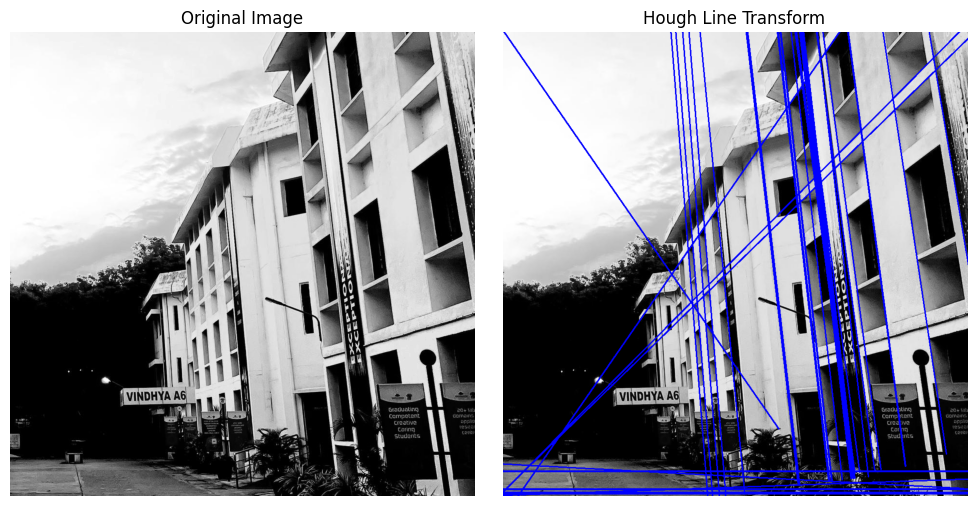

In [41]:
# test the function on the image
# Example usage
highlighted_image, accumulator = hough_line_transform(IMG1, edge_threshold=(50, 150))


# plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(highlighted_image, cmap='gray')
ax[1].set_title('Hough Line Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

### Experiment Results

#### Increasing the Threshold

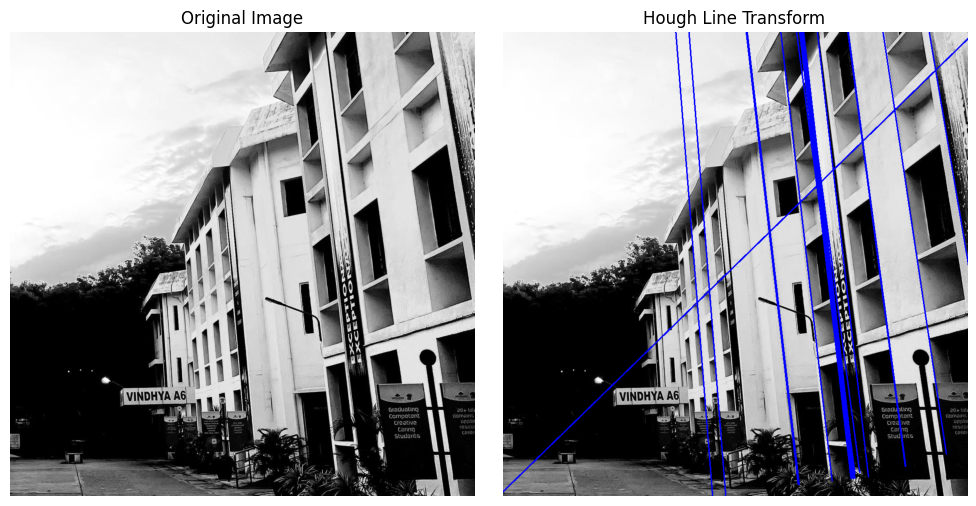

In [43]:
highlighted_image, accumulator = hough_line_transform(IMG1, edge_threshold=(150, 250))


# plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(highlighted_image, cmap='gray')
ax[1].set_title('Hough Line Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Decreasing the Threshold

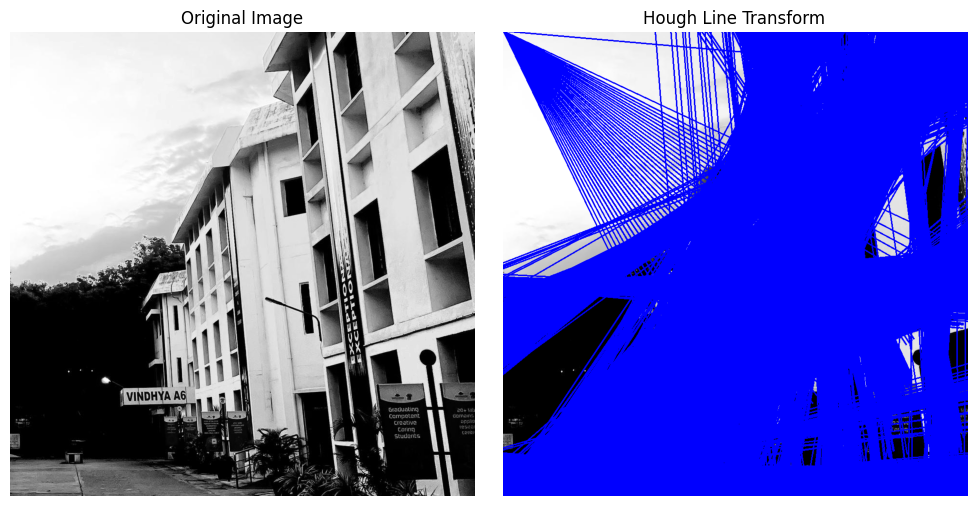

In [44]:
highlighted_image, accumulator = hough_line_transform(IMG1, edge_threshold=(10, 40))


# plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(highlighted_image, cmap='gray')
ax[1].set_title('Hough Line Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Result

Experimenting with the **threshold parameter** in the Hough Transform, which determines the minimum number of votes required to recognize a line, revealed its critical impact on detection quality. **Lower thresholds** resulted in detecting many lines, including weak or noisy ones, leading to cluttered and less meaningful outputs. **Higher thresholds**, on the other hand, filtered out weaker lines, focusing only on prominent ones, but occasionally missed subtle or short line segments in the image. Optimal detection balanced these extremes, identifying clear and relevant lines without over-detection.

## 3. Circle Detection Using Hough Circle Transform

In [ ]:
IMG2 = cv2.imread('../Images/IMG2.jpg', cv2.IMREAD_GRAYSCALE)

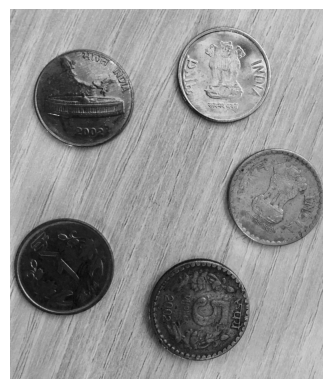

In [47]:
plt.imshow(IMG2, cmap='gray')
plt.axis('off')
plt.show()

### Hough Circle Transform Function

In [52]:
def hough_circle_transform(image, min_radius, max_radius, edge_threshold=(50, 150), radius_step=2, angle_step=5):
    # Preprocessing: Smooth the image to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 1)
    
    # Edge detection
    edges = cv2.Canny(blurred, edge_threshold[0], edge_threshold[1])
    
    # Initialize the accumulator
    height, width = edges.shape
    radius_range = np.arange(min_radius, max_radius, radius_step)
    accumulator = np.zeros((height, width, len(radius_range)), dtype=np.uint64)
    
    # Precompute trigonometric values
    angles = np.arange(0, 360, angle_step)
    cos_vals = np.cos(np.radians(angles))
    sin_vals = np.sin(np.radians(angles))
    
    # Populate the accumulator
    edge_points = np.argwhere(edges)  # Get coordinates of edge points
    for r_idx, radius in enumerate(radius_range):
        for y, x in edge_points:
            for cos_theta, sin_theta in zip(cos_vals, sin_vals):
                a = int(x - radius * cos_theta)
                b = int(y - radius * sin_theta)
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r_idx] += 1

    # Detect peaks in the accumulator
    threshold = 0.5 * accumulator.max()  # Threshold for circle detection
    circles = []
    for r_idx, radius in enumerate(radius_range):
        detected_points = np.argwhere(accumulator[:, :, r_idx] > threshold)
        for y, x in detected_points:
            circles.append((x, y, radius))
    
    # Draw detected circles
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for x, y, radius in circles:
        cv2.circle(output_image, (x, y), radius, (0, 255, 0), 2)
        cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # Draw center
    
    return output_image, circles

### Testing on IMG2

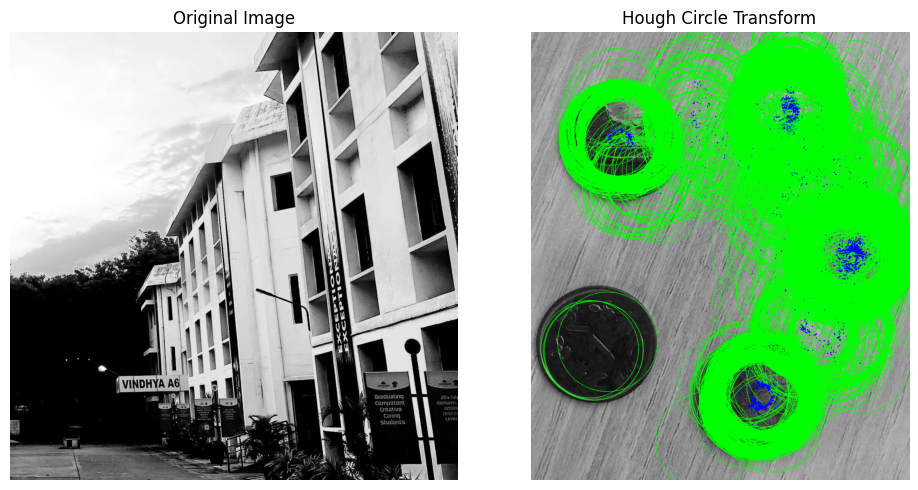

In [69]:
detected_image, circles = hough_circle_transform(IMG2, min_radius=290, max_radius=300)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(detected_image, cmap='gray')
ax[1].set_title('Hough Circle Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

### Experiment

#### Decreasing Radius

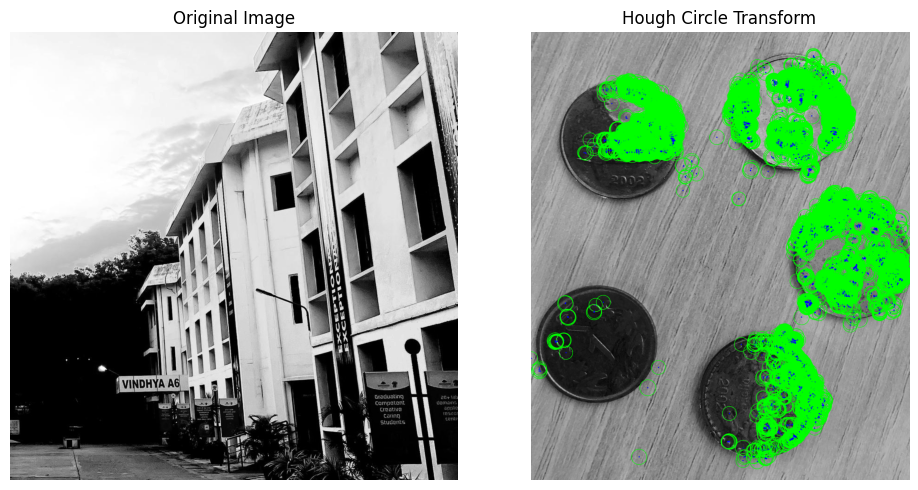

In [54]:
detected_image, circles = hough_circle_transform(IMG2, min_radius=40, max_radius=50)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(detected_image, cmap='gray')
ax[1].set_title('Hough Circle Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Increasing Radius

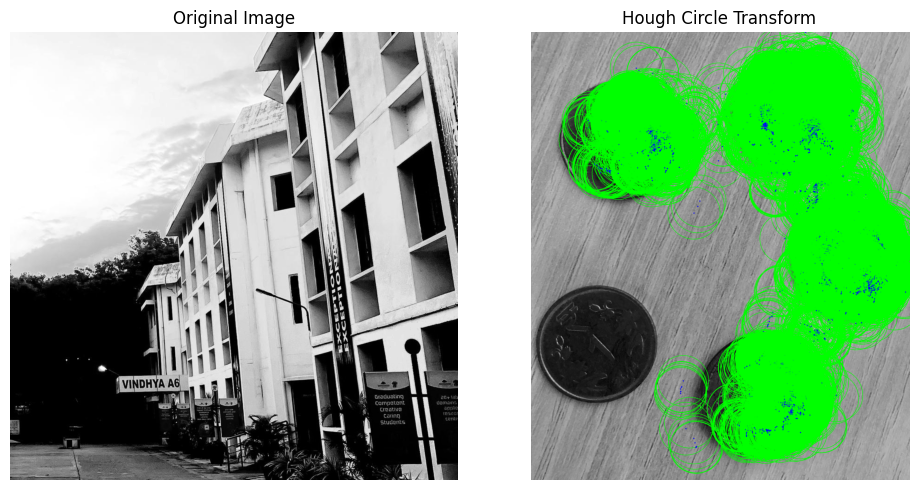

In [56]:
detected_image, circles = hough_circle_transform(IMG2, min_radius=150, max_radius=160)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG1, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(detected_image, cmap='gray')
ax[1].set_title('Hough Circle Transform')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Result

**Improvements Observed:**
Radius Range: A narrow radius range improves detection accuracy and speed for known circle sizes. A wide range increases flexibility but requires careful thresholding.

**Threshold Tuning:**
Higher thresholds improve precision by focusing on strong detections but may miss faint or small circles.
Lower thresholds improve sensitivity but require additional steps to filter false positives.

## 4. Harris Corner Detection

In [ ]:
IMG3 = cv2.imread('../Images/IMG3.jpg', cv2.IMREAD_GRAYSCALE)

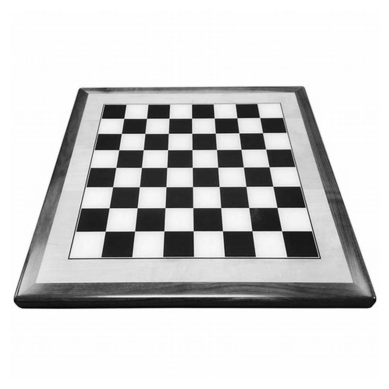

In [58]:
plt.imshow(IMG3, cmap='gray')
plt.axis('off')
plt.show()

### Harris Corner Detection Function

In [64]:
def harris_corner_detection(image, k=0.04, threshold=0.01):
    # Step 1: Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Step 2: Compute image gradients
    gray = np.float32(gray)  # Convert to float32 for precision
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Step 3: Compute products of gradients
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Step 4: Apply Gaussian filtering to the gradient products
    Ixx = cv2.GaussianBlur(Ixx, (5, 5), 1)
    Iyy = cv2.GaussianBlur(Iyy, (5, 5), 1)
    Ixy = cv2.GaussianBlur(Ixy, (5, 5), 1)
    
    # Step 5: Compute the corner response function R
    det_M = Ixx * Iyy - Ixy * Ixy  # Determinant of M
    trace_M = Ixx + Iyy  # Trace of M
    R = det_M - k * (trace_M ** 2)
    
    # Step 6: Threshold and non-maximum suppression
    R_max = R.max()
    corners = np.argwhere(R > threshold * R_max)
    
    # Mark detected corners on the image
    marked_image = image.copy()
    for y, x in corners:
        cv2.circle(marked_image, (x, y), 8, (0, 255, 0), -1)
    
    return marked_image, corners

### Testing on IMG3

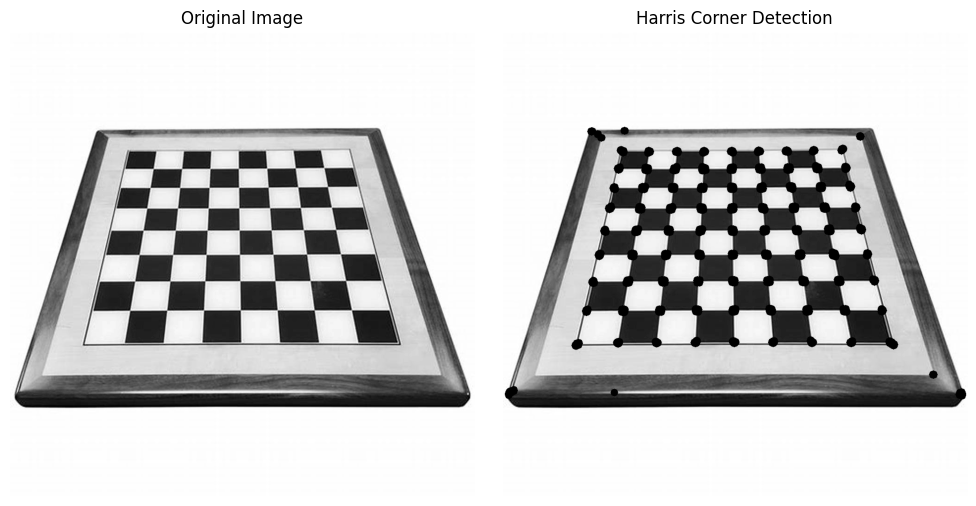

In [65]:
marked_image, detected_corners = harris_corner_detection(IMG3, k=0.04, threshold=0.01)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG3, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(marked_image, cmap='gray')
ax[1].set_title('Harris Corner Detection')
ax[1].axis('off')
plt.tight_layout()
plt.show()

### Experiment

#### Low (k)

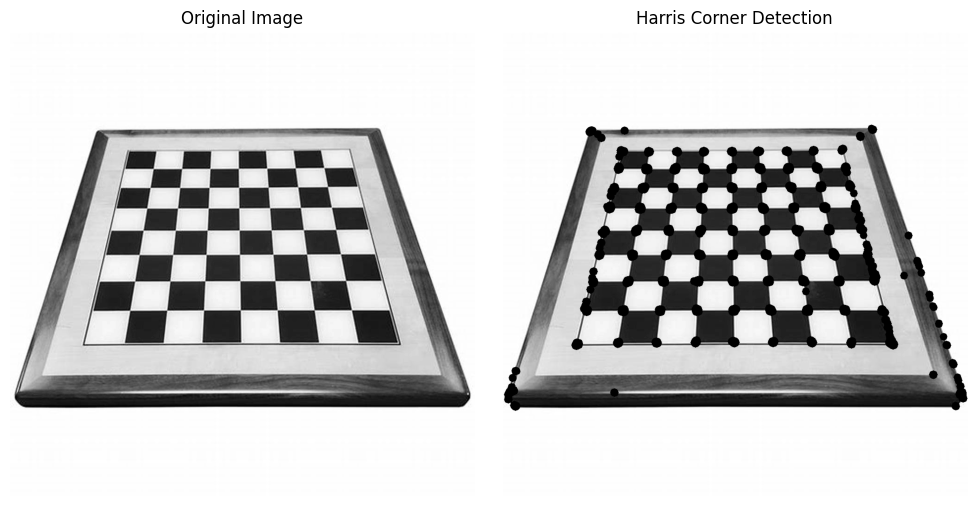

In [66]:
marked_image, detected_corners = harris_corner_detection(IMG3, k=0.01, threshold=0.01)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG3, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(marked_image, cmap='gray')
ax[1].set_title('Harris Corner Detection')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### High (k)

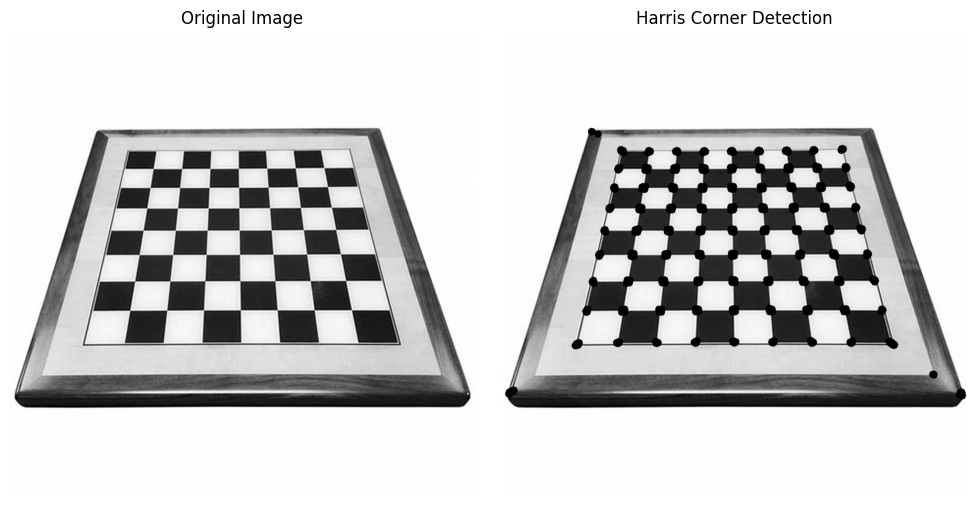

In [67]:
marked_image, detected_corners = harris_corner_detection(IMG3, k=0.1, threshold=0.01)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMG3, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(marked_image, cmap='gray')
ax[1].set_title('Harris Corner Detection')
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Result

Lower values of \( k \) lead to more corners, including noise and less reliable points, while higher values reduce sensitivity but focus on stronger, more defined corners. The choice of \( k \) depends on the level of detail required and the tradeoff between precision and recall in corner detection.

## 5. Short Theory

The Hough Transform detects lines by mapping points in image space to sinusoidal curves in a 2D parameter space (rho, theta), where rho represents the perpendicular distance from the origin and theta the angle. For circles, the transform extends to a 3D parameter space (a, b, r), where a and b are the circle’s center coordinates and r its radius.

Detecting lines requires fewer computations since only two parameters (rho and theta) are involved, resulting in lower memory and time complexity. Detecting circles is more computationally intensive because of the additional radius dimension, requiring a 3D accumulator array and more iterations to vote for all possible circle centers and radii. Thus, circle detection generally demands more preprocessing (e.g., smoothing and edge detection) and optimized thresholds to balance accuracy and efficiency.
